## to do
- [x] get the eye coordinates
- [x] center the data in screen center
- [x] get data from start to end of record clean of nan and blinks
- [x] downsample in TR
- [x] select the data in between two times defined in the eventsphysio
- [x] Smoothing of the data
- [x] check that the real data downsample
- [ ] load the video of vdm
- [ ] shift the video as opposite of the eye position
- [ ] save the change vdm

In [ ]:
def extract_events(tsvgz_fn, json_fn):
    """
    Load and process eye-tracking physio events data and associated metadata
    from TSV and JSON files.

    Args:
		tsvgz_fn (str): eye-tracking _physio.tsv.gz filename and path
	    json_fn (str): eye-tracking _physio.json filename and path
  
    Returns:
        events_data: eye-tracking physio events dataframe of the data
        events_metadata: eye-tracking physio events dictionary of the metadata
    """

    import json 
    import pandas as pd
    
    # Extract metadata from the JSON
    with open(json_fn, 'r') as file:
        events_metadata = json.load(file)
    
    column_names = events_metadata['Columns']
    
    # Get data
    events_data = pd.read_csv(tsvgz_fn, 
                              compression='gzip', 
                              delimiter='\t', 
                              header=None,
                              names=column_names,  # Use the column names from JSON
                              na_values='n/a' # Treat 'n/a' as NaN
                             )
    
    return events_data, events_metadata

def extract_data(tsvgz_fn, json_fn, x_coord_column, y_coord_column, pupil_column, 
                 pixel_per_dva, screen_center_x, screen_center_y, 
                 start_time=None, end_time=None, smooth_method=None,
                 smooth_window=None, smooth_sigma=None):
    """
    Load and process eye-tracking data and associated metadata from TSV and JSON files.
    Output only data in between start and stoptime as get in the JSON file.

    Args:
		tsvgz_fn (str): eye-tracking _physio.tsv.gz filename and path
	    json_fn (str): eye-tracking _physio.json filename and path
        x_coord_column (str): name of the X coordinate column
        y_coord_column (str): name of the X coordinate column
        pupil_column (str): name of the pupil column
        pixel_per_dva(float): pixel per degrees of visual angle
        screen_center_x(float): screen center pixel coordinate x
        screen_center_y(float): screen center pixel coordinate y
        start_time(int, optional): timestamps run onset
        end_time(int, optional): timestamps run offset
        smooth_method(str): method for smoothing ('moving_avg', 'gaussian')
        smooth_window(float): smoothing window in millisecond
        smooth_sigma(float): sd of the guassian
  
    Returns:
        et_data_rec: eye-tracking dataframe of the data after the start signal
        et_metadata: eye-tracking dictionary of the metadata
    """

    import json 
    import pandas as pd
    
    # Extract metadata from the JSON
    with open(json_fn, 'r') as file:
        et_metadata = json.load(file)
    
    column_names = et_metadata['Columns']

    # Use provided start_time/end_time if available, otherwise fall back to metadata
    if start_time is None:
        start_time = int(et_metadata['StartTime'][0])
    if end_time is None:
        end_time = int(et_metadata['StopTime'][0])


    # smoothing method
    if smooth_method is None:
        smooth_method='NaN'
    if smooth_window is None: 
        smooth_window = 'NaN'
    if smooth_sigma is None: 
        smooth_sigma = 'NaN'    

    # Add data columns
    et_metadata['x_coord_column'] = x_coord_column
    et_metadata['y_coord_column'] = y_coord_column
    et_metadata['pupil_column'] = pupil_column
    et_metadata['pixel_per_dva'] = pixel_per_dva
    et_metadata['screen_center_x'] = screen_center_x
    et_metadata['screen_center_y'] = screen_center_y
    et_metadata['start_time'] = start_time
    et_metadata['end_time'] = end_time
    et_metadata['smooth_method'] = smooth_method
    et_metadata['smooth_window'] = smooth_window
    et_metadata['smooth_sigma'] = smooth_sigma

    # Get data
    df = pd.read_csv(tsvgz_fn, 
                     compression='gzip', 
                     delimiter='\t', 
                     header=None,
                     names=column_names,  # Use the column names from JSON
                     na_values='n/a' # Treat 'n/a' as NaN
                    )
    
    # Get experiment data 
    # first column is necessarily the timestamps in physio tsv.gz
    et_data_rec = df[(df[df.columns[0]] >= start_time) & (df[df.columns[0]] <= end_time)]
    
    return et_data_rec, et_metadata

def blink_removal(et_data, et_metadata, blink_removal_method, blink_buffer=None):
    """
    Replace blinks in eye-tracking data with NaN

    Args:
        et_data: eye-tracking dataframe
        et_metadata: eye-tracking dictionary of the metadata
        blink_removal_method: blink removal method
        blink_buffer: Period before and after detected blink to nan (default = None) 
        
    Returns:
        et_data_blinkless: dataframe cleaned from blink
    """
    import numpy as np

    if blink_removal_method == 'pupil_off':
        blink_bool = (et_data[et_metadata['pupil_column']] == 0)
        et_data_blinkless = et_data.copy()
        et_data_blinkless.loc[blink_bool, [et_metadata['x_coord_column'],
                                            et_metadata['y_coord_column'], 
                                            et_metadata['pupil_column']]] = np.nan
        
        # Add blink buffer
        if blink_buffer is not None:
            blink_buffer_samples = int(blink_buffer * et_metadata['SamplingFrequency'])
            blink_indices = et_data_blinkless.index[blink_bool]

            for blink_index in blink_indices:
                start_index = max(blink_index - blink_buffer_samples, et_data_blinkless.index.min())
                end_index = min(blink_index + blink_buffer_samples, et_data_blinkless.index.max())
                et_data_blinkless.loc[start_index:end_index, [et_metadata['x_coord_column'],
                                                               et_metadata['y_coord_column'], 
                                                               et_metadata['pupil_column']]] = np.nan

    return et_data_blinkless

def nan_removal(et_data, et_metadata):
    """
    Remove nan with either interpolation or extrapolation of the data.
    
    Args:
        et_data: eye-tracking dataframe
        et_metadata: eye-tracking dictionary of the metadata
    
    Returns:
        et_data_nanless: eye-tracking dataframe cleaned from nans
    """
    import numpy as np
    from scipy.interpolate import interp1d

    data_columns = [et_metadata['x_coord_column'], 
                    et_metadata['y_coord_column'], 
                    et_metadata['pupil_column']]
    
    # Create a copy of the original DataFrame to store the results
    et_data_nanless = et_data.copy()
    
    for data_column in data_columns:
        # Access the specific column directly from the DataFrame
        et_data_col = et_data_nanless[data_column].copy()
        
        # Create a mask for NaN values
        nan_indices = np.isnan(et_data_col)

        # Get the indices of the valid (non-NaN) values
        valid_indices = np.arange(len(et_data_col))[~nan_indices]
        valid_values = et_data_col[~nan_indices]
        
        # Create an interpolation function
        interp_func = interp1d(x=valid_indices,
                               y=valid_values, 
                               kind='linear',
                               bounds_error=False, 
                               fill_value="extrapolate")
        
        # Interpolate the NaN values
        et_data_col[nan_indices] = interp_func(np.arange(len(et_data_col))[nan_indices])
        
        # Update the original DataFrame with the interpolated values
        et_data_nanless[data_column] = et_data_col

    return et_data_nanless

def center_data(et_data, et_metadata):
    """
    Center the data in screen center as a function of the coordinate system
    
    Args:
        et_data: eye-tracking dataframe
        et_metadata: eye-tracking dictionary of the metadata
    
    Returns:
        et_data_center: eye-tracking dataframe centered on screen center
    """    
    et_data_center = et_data.copy()

    et_data_center[metadata_rec['x_coord_column']] = et_data_center[metadata_rec['x_coord_column']] - metadata_rec['screen_center_x']
    et_data_center[metadata_rec['y_coord_column']] = et_data_center[metadata_rec['y_coord_column']] - metadata_rec['screen_center_y']
    
    return et_data_center


def convert_to_dva(et_data, et_metadata):
    """
    Remove nan with either interpolation or extrapolation of the data.
    
    Args:
        et_data: eye-tracking dataframe
        et_metadata: eye-tracking dictionary of the metadata
        ppd : pixel per degree
    
    Returns:
        et_data_dva: eye-tracking dataframe in degrees of visual angle
    """

    et_data_dva = et_data.copy()
    et_data_dva[metadata_rec['x_coord_column']] = et_data_dva[metadata_rec['x_coord_column']] / metadata_rec['pixel_per_dva']
    et_data_dva[metadata_rec['y_coord_column']] = et_data_dva[metadata_rec['y_coord_column']] / metadata_rec['pixel_per_dva']

    return et_data_dva


def downsample_to_tr(et_data, et_metadata, tr_number, tr_duration):
    """
    Downsample eye-tracking data to match the temporal resolution of functional MRI TRs.
    
    Args:
        et_data: eye-tracking dataframe
        et_metadata: eye-tracking dictionary of the metadata
        tr_number: number of TRs
        tr_duration: duration of a TR
    
    Returns:
        et_data_downsampled: eye-tracking dataframe downsample to match the TR duration
    """
    
    from scipy.signal import resample
    import pandas as pd
    import numpy as np

    et_data_downsampled = pd.DataFrame()
    et_data_downsampled['timestamp'] = np.arange(tr_number) * (tr_duration) + (tr_duration)/2
    et_data_downsampled[et_metadata['x_coord_column']] = resample(et_data[et_metadata['x_coord_column']], tr_number)
    et_data_downsampled[et_metadata['y_coord_column']] = resample(et_data[et_metadata['y_coord_column']], tr_number)
    
    return et_data_downsampled

def smooth_data(et_data, et_metadata):
    """
    Apply smoothing to eye-tracking data using specified method.
    
    Args:
        et_data (pd.DataFrame): Eye-tracking data containing coordinate columns.
        et_metadata (dict): Metadata dictionary containing:
            - 'x_coord_column': Name of X coordinate column
            - 'y_coord_column': Name of Y coordinate column  
            - 'smooth_window': Smoothing window duration in milliseconds (for moving_avg method)
            - 'sampling_rate': Sampling rate of the data in Hz
            - 'sigma': Standard deviation for Gaussian filter
    Returns:
        pd.DataFrame: Smoothed data with smoothing applied to X and Y coordinates.
    """
    et_data_smooth = et_data.copy()
    if et_metadata['smooth_method'] == 'moving_avg':
        window_samples = int((et_metadata['smooth_window'] / 1000.0) * et_metadata['SamplingFrequency'])
        et_data_smooth[et_metadata['x_coord_column']] = et_data_smooth[et_metadata['x_coord_column']].rolling(window=window_samples).mean().bfill()
        et_data_smooth[et_metadata['y_coord_column']] = et_data_smooth[et_metadata['y_coord_column']].rolling(window=window_samples).mean().bfill()
    
    elif et_metadata['smooth_method'] == 'gaussian':
        from scipy.ndimage import gaussian_filter1d
        et_data_smooth[et_metadata['x_coord_column']] = gaussian_filter1d(et_data_smooth[et_metadata['x_coord_column']], sigma=et_metadata['sigma'])
        et_data_smooth[et_metadata['y_coord_column']] = gaussian_filter1d(et_data_smooth[et_metadata['y_coord_column']], sigma=et_metadata['sigma'])

    return et_data_smooth

In [24]:
# Settings path
x_coord_column = 'x_coordinate'
y_coord_column = 'y_coordinate'
pupil_column = 'pupil_size'
blink_removal_method = 'pupil_off'
smooth_method = 'moving_avg'
smooth_window = 1000
blink_buffer = 0.500
pixel_per_dva = 52
screen_center_x = 960
screen_center_y = 540
TRs = 208
TR_dur = 1.2

# Data path
tsvgz_data_fn = '/home/mszinte/disks/meso_S/data/RetinoMaps/derivatives/vdm/test/sub-04_ses-01_task-pRF_run-01_recording-eye1_physio.tsv.gz'
json_data_fn = '/home/mszinte/disks/meso_S/data/RetinoMaps/derivatives/vdm/test/sub-04_ses-01_task-pRF_run-01_recording-eye1_physio.json'
tsvgz_events_fn = '/home/mszinte/disks/meso_S/data/RetinoMaps/derivatives/vdm/test/sub-04_ses-01_task-pRF_run-01_recording-eye1_physioevents.tsv.gz'
json_events_fn = '/home/mszinte/disks/meso_S/data/RetinoMaps/derivatives/vdm/test/sub-04_ses-01_task-pRF_run-01_recording-eye1_physioevents.json'

In [25]:
# Extract events
events_data, events_metadata = extract_events(tsvgz_events_fn, json_events_fn)
run_start_msg = 'bar pass 1 trial onset 1'
run_end_msg = 'bar pass 9 stopped'
run_start_timestamp = int(events_data[events_data['message']==run_start_msg]['onset'].iloc[0])
run_end_timestamp = int(events_data[events_data['message']==run_end_msg]['onset'].iloc[0])


In [26]:
# Extract data
data_rec, metadata_rec = extract_data(tsvgz_fn=tsvgz_data_fn,
                                      json_fn=json_data_fn,
                                      x_coord_column=x_coord_column,
                                      y_coord_column=y_coord_column,
                                      pupil_column=pupil_column,
                                      pixel_per_dva=pixel_per_dva,
                                      screen_center_x=screen_center_x,
                                      screen_center_y=screen_center_y,
                                      start_time=run_start_timestamp,
                                      end_time=run_end_timestamp,
                                      smooth_method=smooth_method,
                                      smooth_window=smooth_window
                                     )

data_rec_blinkless = blink_removal(et_data=data_rec,
                                   et_metadata=metadata_rec,
                                   blink_removal_method=blink_removal_method,
                                   blink_buffer=blink_buffer)

data_rec_blinkless_nanless = nan_removal(et_data=data_rec_blinkless,
                                         et_metadata=metadata_rec)

data_rec_blinkless_nanless_center = center_data(et_data=data_rec_blinkless_nanless,
                                                et_metadata=metadata_rec)

data_rec_blinkless_nanless_center_dva = convert_to_dva(et_data=data_rec_blinkless_nanless_center,
                                                       et_metadata=metadata_rec)


data_rec_blinkless_nanless_center_dva_smooth = smooth_data(et_data=data_rec_blinkless_nanless_center_dva,
                                                           et_metadata=metadata_rec)

data_rec_blinkless_nanless_center_dva_smooth_downsampled = downsample_to_tr(et_data=data_rec_blinkless_nanless_center_dva_smooth, 
                                                                            et_metadata=metadata_rec,
                                                                            tr_number=TRs,
                                                                            tr_duration=TR_dur)

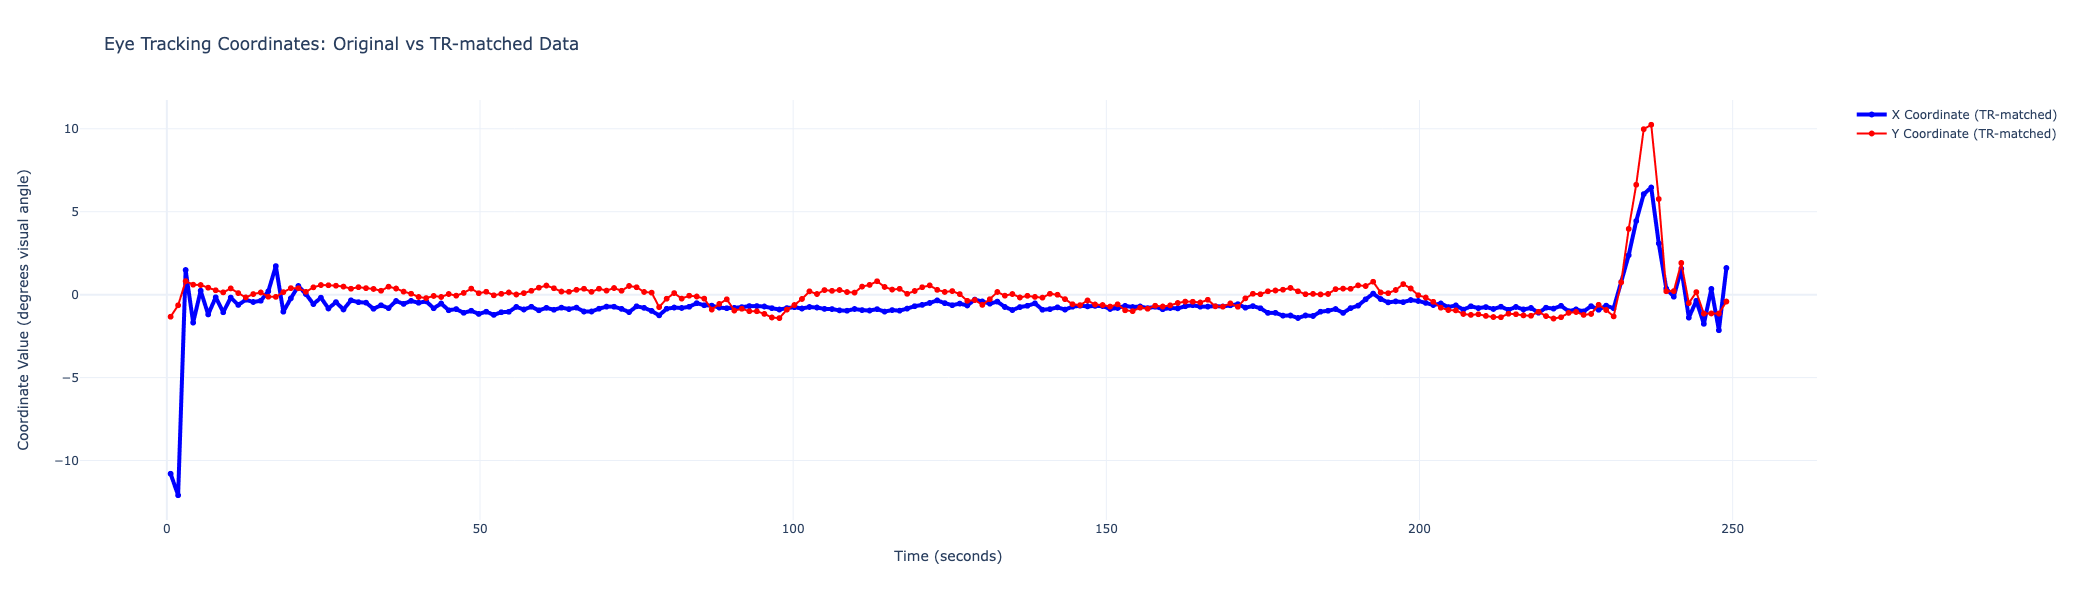

In [31]:
import plotly.graph_objects as go
import numpy as np

# Calculate time in seconds
time = (data_rec_blinkless_nanless_center_dva_smooth['timestamp'] - metadata_rec['start_time']) / 1000
x_coords = data_rec_blinkless_nanless_center_dva_smooth['x_coordinate']
y_coords = data_rec_blinkless_nanless_center_dva_smooth['y_coordinate']

# Get downsampled data (208 values only)
x_coords_downsampled = data_rec_blinkless_nanless_center_dva_smooth_downsampled['x_coordinate']
y_coords_downsampled = data_rec_blinkless_nanless_center_dva_smooth_downsampled['y_coordinate']
time_downsampled = data_rec_blinkless_nanless_center_dva_smooth_downsampled['timestamp']

# Create optimized plot
fig = go.Figure()

# # Original data with lines (high resolution)
# fig.add_trace(go.Scattergl(
#     x=time, y=x_coords, mode='lines', name='X Coordinate (Original)',
#     line=dict(color='lightblue', width=2)
# ))

# fig.add_trace(go.Scattergl(
#     x=time, y=y_coords, mode='lines', name='Y Coordinate (Original)',
#     line=dict(color='lightcoral', width=1)
# ))

# Downsampled data with visible markers (208 points)
fig.add_trace(go.Scattergl(
    x=time_downsampled, y=x_coords_downsampled, 
    mode='markers+lines', name='X Coordinate (TR-matched)',
    line=dict(color='blue', width=4)))

fig.add_trace(go.Scattergl(
    x=time_downsampled, y=y_coords_downsampled, 
    mode='markers+lines', name='Y Coordinate (TR-matched)',
    line=dict(color='red', width=2)))


# Optimized layout
fig.update_layout(
    title='Eye Tracking Coordinates: Original vs TR-matched Data',
    xaxis_title='Time (seconds)',
    yaxis_title='Coordinate Value (degrees visual angle)',
    width=1000, height=600,
    hovermode='x unified',  # More efficient hover
    template='plotly_white',
    xaxis=dict(showgrid=True, showspikes=False),
    yaxis=dict(showgrid=True, showspikes=False),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

# Show with performance config
fig.show(config={'scrollZoom': True, 'displaylogo': False})

In [38]:
import cv2

# Define video settings 
tasks = ['pRF']
task = tasks[0]
stim_video_fn = '/home/mszinte/disks/meso_S/data/RetinoMaps/derivatives/vdm/{}_vid.mp4'.format(task)

In [41]:
# open video
cap = cv2.VideoCapture(stim_video_fn)

# get video settings
vid_width, vid_height = cap.get(3), cap.get(4)
vid_fps = cap.get(cv2.CAP_PROP_FPS)
vid_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# set VDM settings
vdm_width = 1920 
vdm_height = 1080

vdm_frames_sampled = vid_fps * TR_dur
vdm_frames = vid_frames / vdm_frames_sampled
vdm_mat = np.zeros((vdm_width, vdm_height, int(vdm_frames)))
height_to_add = (vid_width - vid_height) / 2 
add_mat =  np.zeros((int(height_to_add),int(vid_width)))

In [42]:
vdm_mat.shape

(1920, 1080, 208)

In [40]:
# create VDM matrix
vid_idx, vdm_idx = 0, 0
while(cap.isOpened()):
    
    # read video frames
    ret, vid_frame = cap.read()
    if not ret: break

    # process sampled frames
    if np.mod(vid_idx, int(vdm_frames_sampled)) == 0:

        # convert frame to grayscale
        gray_mat = cv2.cvtColor(vid_frame, cv2.COLOR_BGR2GRAY)

        # convert to binary
        binary_mat = (gray_mat > 5).astype(np.uint8)
    
        # add top and bottom blank    
        binary_reshape_mat = np.concatenate((add_mat,binary_mat,add_mat), axis=0)
        
        # resize to create VDM
        binary_reshape_resize_mat = cv2.resize(binary_reshape_mat, dsize=(vdm_width, vdm_height),
                                               interpolation=cv2.INTER_NEAREST)
        
        # fill VDM matrix
        vdm_mat[...,vdm_idx] = binary_reshape_resize_mat
        vdm_idx += 1


    vid_idx += 1
    
cap.release()

ValueError: could not broadcast input array from shape (1080,1920) into shape (1920,1080)